/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Aggregated Labor Shortage Risk (from all files): 0.36
Aggregated Cost Std % (from all files): 7.14
Deterministic base: 12 months, £520.00k

=== Summary statistics ===
       Total Duration (months)  Total Cost (£k)
count            100000.000000    100000.000000
mean                 14.656831       533.281926
std                   3.258776        46.000050
min                   5.415068       370.145811
50%                  14.313055       531.298132
80%                  17.218556       571.125269
95%                  20.563323       611.870002
max                  33.381403       777.427884

P50 Duration: 14.31 mo | P80: 17.22 | P95: 20.56
P50 Cost: £531.30k | P80: £571.13k | P95: £611.87k
Mean overruns vs deterministic base — Duration: 22.1% | Cost: 2.6%
Correlation(Duration, Cost): 0.36
Correlation(Materials, Total Cost): 0.72

Saved: mcs_results.csv


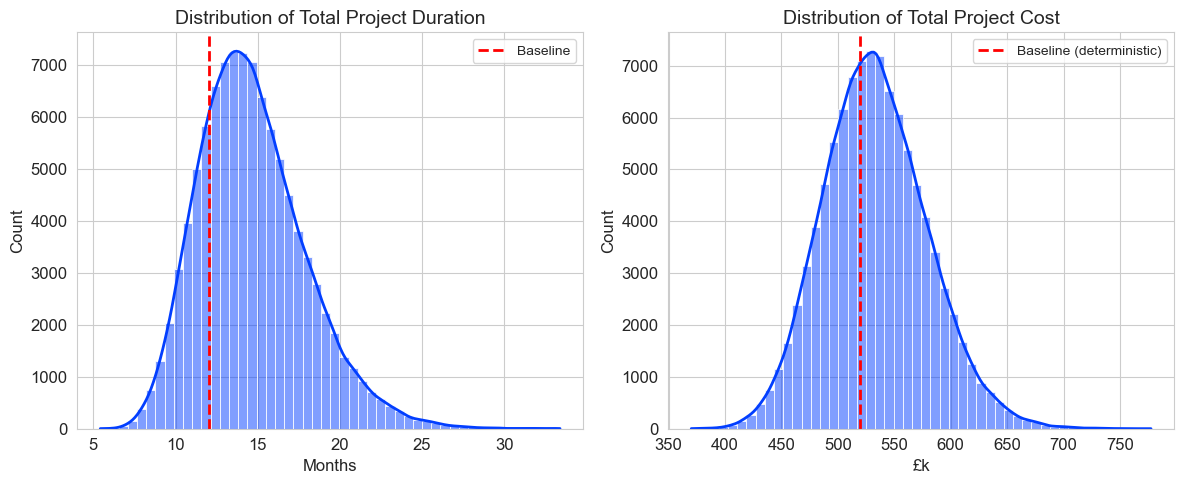

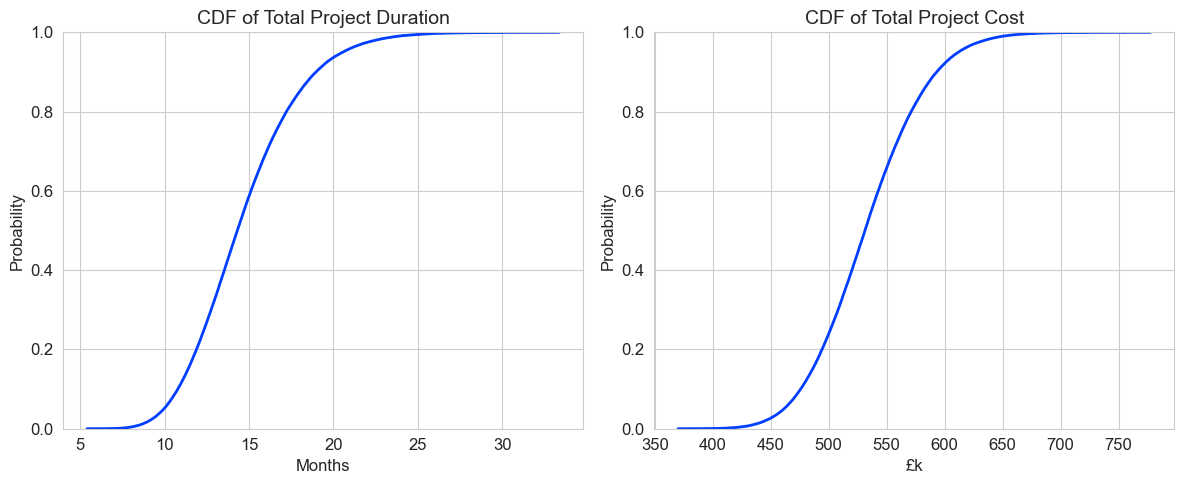

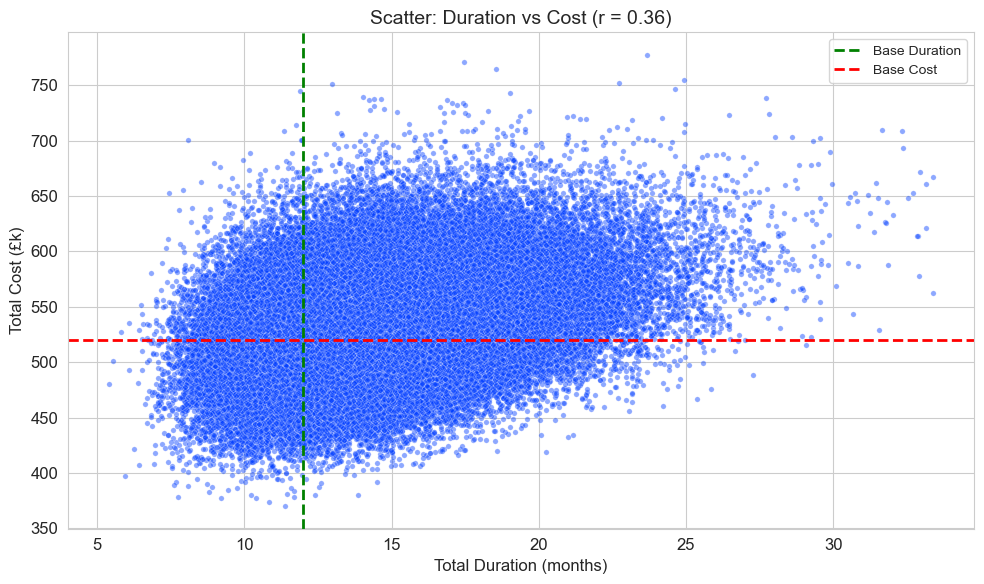

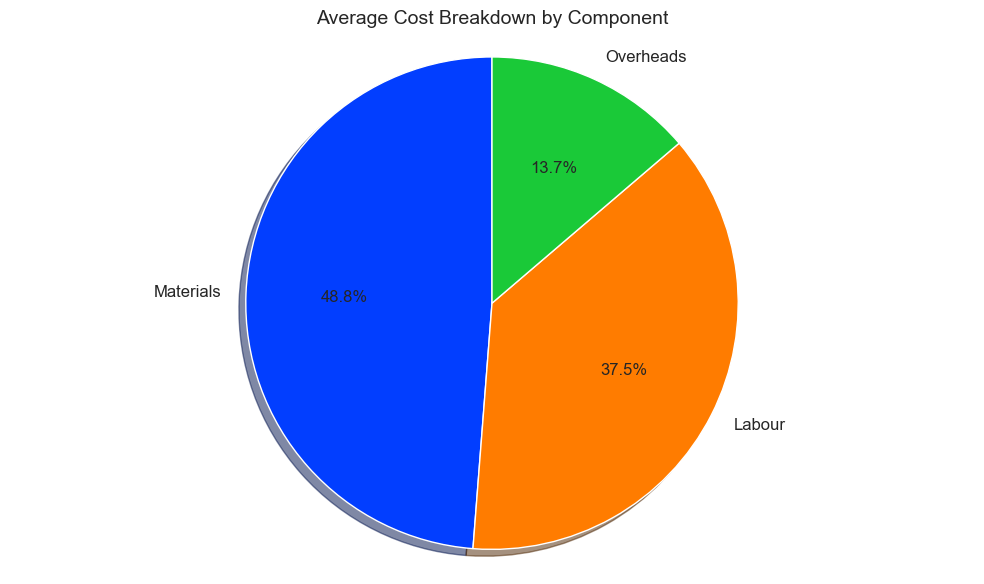

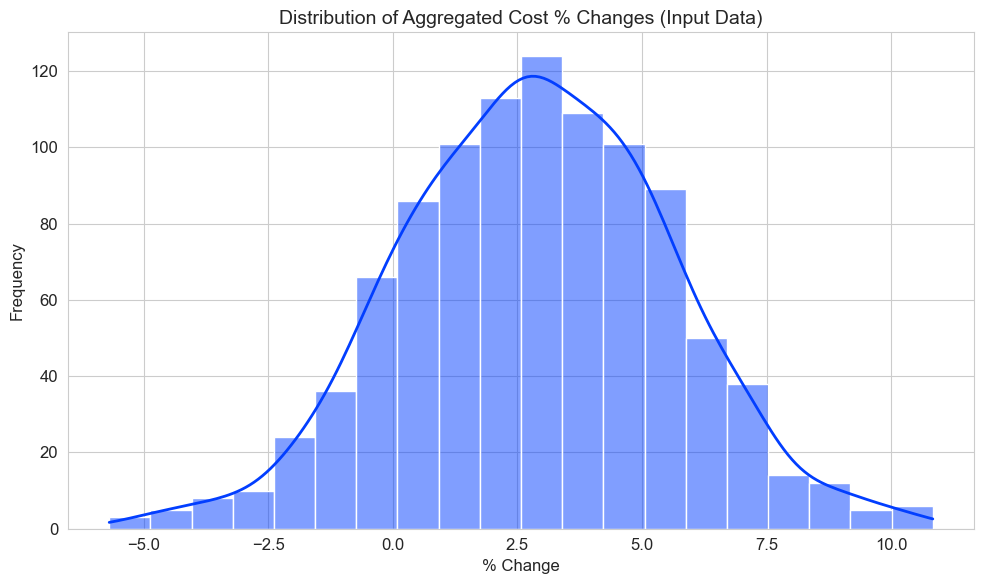

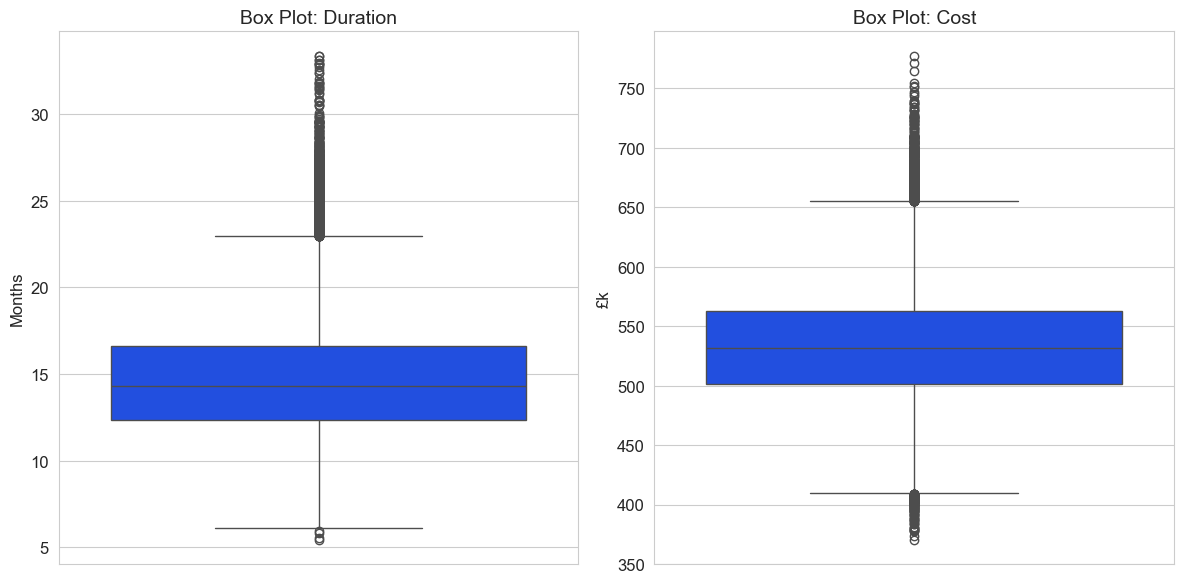

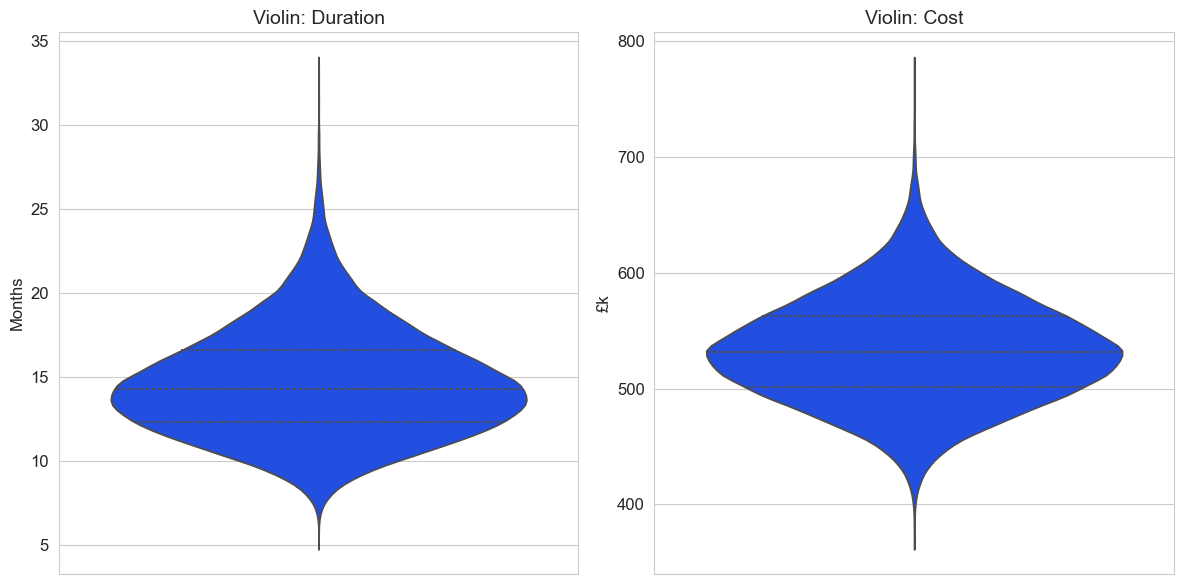

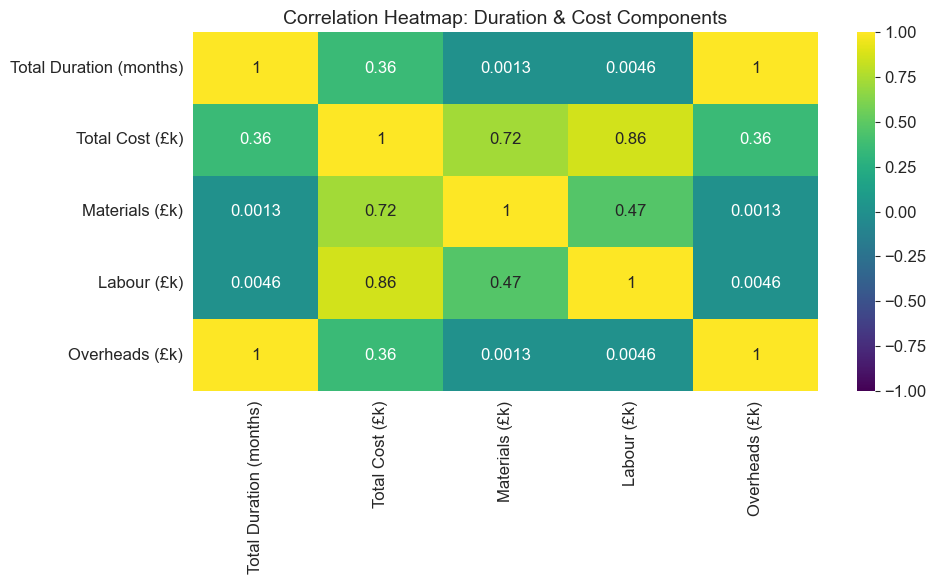

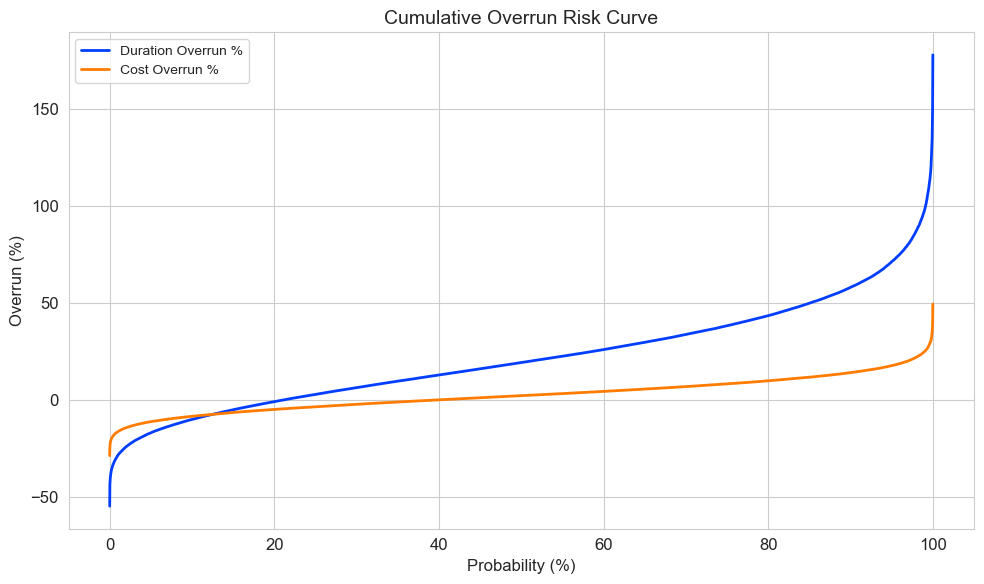

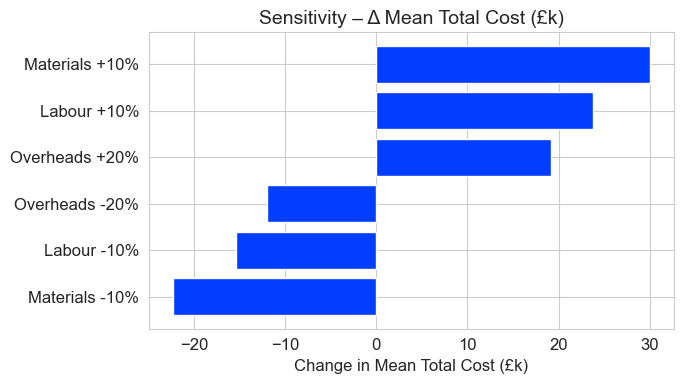


Saved plots: distributions_hist.png, cdfs.png, scatter_duration_cost.png, pie_cost_breakdown.png, hist_cost_changes.png, boxplot_results.png, violin_distributions.png, correlation_heatmap.png, cumulative_overrun_line.png, sensitivity_tornado.png

Baseline Scenario: P50 Dur 14.28 mo, P95 20.53 mo | P50 Cost £531.37k, P95 £611.91k

High Inflation Scenario: P50 Dur 14.30 mo, P95 20.47 mo | P50 Cost £530.91k, P95 £616.12k

High Labor Shortage Scenario: P50 Dur 15.70 mo, P95 22.94 mo | P50 Cost £538.60k, P95 £621.22k


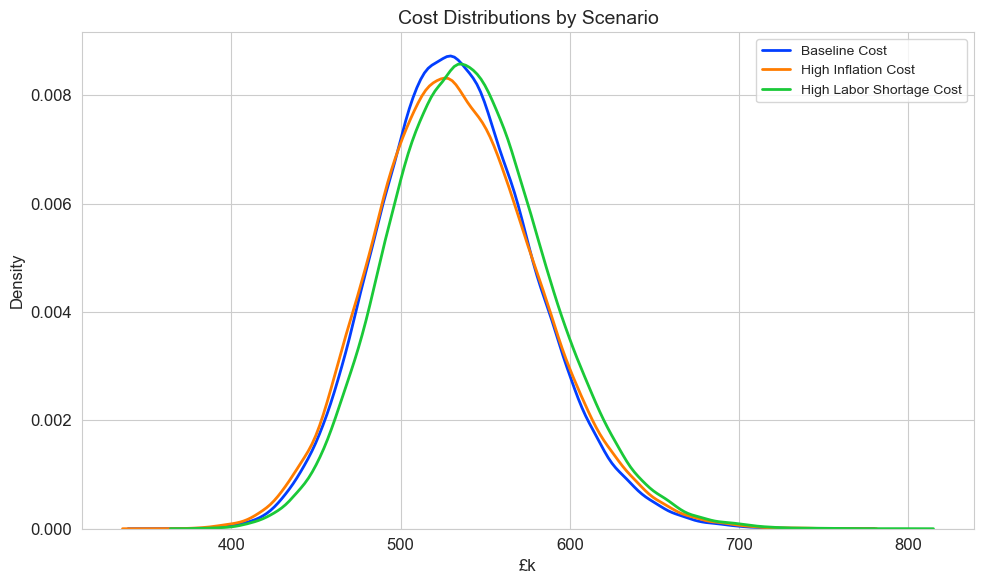

In [9]:
# ============================================
# Monte Carlo – Construction SME Risk (Cost & Schedule)
# ============================================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from scipy.stats import triang, norm, lognorm, pearsonr
import seaborn as sns
import os

# Plot style
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.rcParams.update({
    'font.size': 12, 'figure.figsize': (10, 6),
    'axes.titlesize': 14, 'axes.labelsize': 12,
    'legend.fontsize': 10, 'lines.linewidth': 2
})
np.random.seed(42)

# ======================================================
# 1) DATA LOADERS FOR ALL FILES (volatility proxies)
# ======================================================
def parse_csv_text(txt):
    lines = txt.splitlines()
    first = next(i for i, ln in enumerate(lines) if re.match(r'^\s*"?\d{4}', ln))
    df = pd.read_csv(StringIO("\n".join(lines[first:])), header=None, names=["date", "vacancies"])
    df["vacancies"] = pd.to_numeric(df["vacancies"], errors="coerce")
    return df.dropna()

def load_vacancy_risk(path="series-310725.csv"):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        txt = f.read()
    df = parse_csv_text(txt)
    mean_v = df["vacancies"].mean()
    std_v = df["vacancies"].std(ddof=1)
    return std_v / max(mean_v, 1e-9)

def parse_xlsx_rows(df_list):
    sheets = {}
    current_sheet = None
    for row in df_list:
        if '<SHEET' in row:
            current_sheet = re.search(r'name="([^"]+)"', row).group(1) if re.search(r'name="([^"]+)"', row) else None
            if current_sheet:
                sheets[current_sheet] = []
        elif row.startswith('row') and current_sheet:
            sheets[current_sheet].append(row.split(':', 1)[1].strip() if ':' in row else row)
    return sheets

def load_opi_changes(path="bulletindataset9.xlsx", sheet_hint="All construction"):
    xls = pd.ExcelFile(path)
    sheet = next((s for s in xls.sheet_names if sheet_hint.lower() in s.lower()), xls.sheet_names[0])
    df = xls.parse(sheet_name=sheet)
    df.columns = [str(c).replace("\n", " ").strip() for c in df.columns]
    cands = [c for c in df.columns if ("percentage" in c.lower() and "1 month" in c.lower())]
    if not cands:
        nums = [c for c in df.columns if pd.to_numeric(df[c], errors="coerce").notna().sum() > 10]
        col = nums[-1] if nums else None
    else:
        col = cands[0]
    ser = pd.to_numeric(df[col], errors="coerce").dropna()
    return ser.mean(), ser.std(ddof=1)

def load_structure_weights(path="Construction Industry Structure 2024.xlsx"):
    df = pd.read_excel(path, sheet_name=0)
    df.columns = [str(c).strip() for c in df.columns]
    uk_row = df[df.iloc[:, 0].astype(str).str.strip().str.upper() == "UK"]
    if uk_row.empty: return 0
    weights = pd.to_numeric(uk_row.iloc[0, 1:], errors="coerce").dropna()
    return weights.std() / weights.mean() if not weights.empty else 0

def load_gmpp_variance(path="Government_Major_Projects_Portofolio_AR_Data_March_2024.xlsx"):
    df = pd.read_excel(path, sheet_name=0)
    var_col = next((i for i, val in enumerate(df.iloc[0]) if "Variance (%)" in str(val)), None)
    if var_col is None: return 0
    vars = pd.to_numeric(df.iloc[1:, var_col], errors="coerce").dropna().abs()
    return vars.mean() / 100

def load_new_orders_changes(path="bulletindataset7.xlsx", sheet_hint="Table 8"):
    xls = pd.ExcelFile(path)
    sheet = next((s for s in xls.sheet_names if sheet_hint in s), xls.sheet_names[0])
    df = xls.parse(sheet_name=sheet)
    growth_col = next((i for i in range(df.shape[1]) if "%" in ''.join(df.iloc[:, i].astype(str).str.lower())), -1)
    ser = pd.to_numeric(df.iloc[:, growth_col], errors="coerce").dropna()
    return ser.mean(), ser.std(ddof=1)

def load_output_changes(path="output-in-the-construction-industry-time-series-v26.xlsx"):
    xls = pd.ExcelFile(path)
    sheet = 'Dataset' if 'Dataset' in xls.sheet_names else xls.sheet_names[0]
    df = xls.parse(sheet_name=sheet)
    ser = pd.to_numeric(df.iloc[:, -1], errors="coerce").dropna()  # Assume last col
    pct = ser.pct_change().dropna() * 100
    return pct.mean(), pct.std(ddof=1)

def load_earnings_growth(path="earn03jul2025.xls"):
    df = pd.read_excel(path, sheet_name=0)  # Assume first sheet has data
    growth_col = next((i for i in range(df.shape[1]) if '%' in ''.join(df.iloc[:, i].astype(str).str.lower()) or 'growth' in ''.join(df.iloc[:, i].astype(str).str.lower())), -1)
    ser = pd.to_numeric(df.iloc[:, growth_col], errors="coerce").dropna()
    return ser.mean(), ser.std(ddof=1)

def load_building_materials_changes(path="Construction_building_materials_-_tables_February_2025.xlsx", sheet_hint="1a"):
    xls = pd.ExcelFile(path)
    sheet = next((s for s in xls.sheet_names if sheet_hint in s), xls.sheet_names[0])
    df = xls.parse(sheet_name=sheet)
    price_col = next((i for i in range(df.shape[1]) if "index" in ''.join(df.iloc[:, i].astype(str).str.lower())), -1)
    ser = pd.to_numeric(df.iloc[:, price_col], errors="coerce").dropna()
    pct = ser.pct_change().dropna() * 100
    return pct.mean(), pct.std(ddof=1)

# Load all
vac_cv = load_vacancy_risk()
opi_mean, opi_std = load_opi_changes()
structure_cv = load_structure_weights()
gmpp_var = load_gmpp_variance()
no_mean, no_std = load_new_orders_changes()
out_mean, out_std = load_output_changes()
earn_mean, earn_std = load_earnings_growth()
mat_mean, mat_std = load_building_materials_changes()

# Aggregate risks (use all)
labor_risks = [vac_cv, earn_std / 100 if earn_std else 0, gmpp_var, structure_cv, no_std / 100 if no_std else 0, out_std / 100 if out_std else 0]
cost_risks = [opi_std / 100 if opi_std else 0, mat_std / 100 if mat_std else 0, no_std / 100 if no_std else 0, out_std / 100 if out_std else 0, gmpp_var]
labor_shortage_risk = np.mean([r for r in labor_risks if r > 0])
cost_std = np.mean([r for r in cost_risks if r > 0]) * 100  # %

print(f"Aggregated Labor Shortage Risk (from all files): {labor_shortage_risk:.2f}")
print(f"Aggregated Cost Std % (from all files): {cost_std:.2f}")

# ======================================================
# 2) BASELINE PROJECT (nominal, no inflation baked in)
# ======================================================
tasks = [
    {'name': 'Planning', 'base_duration': 1, 'material_cost_base': 10, 'labor_cost_base': 20},
    {'name': 'Foundation', 'base_duration': 2, 'material_cost_base': 50, 'labor_cost_base': 40},
    {'name': 'Structure', 'base_duration': 3, 'material_cost_base': 100, 'labor_cost_base': 60},
    {'name': 'Finishing', 'base_duration': 4, 'material_cost_base': 80, 'labor_cost_base': 50},
    {'name': 'Inspection', 'base_duration': 2, 'material_cost_base': 20, 'labor_cost_base': 30},
]
base_total_duration = sum(t['base_duration'] for t in tasks) # 12 months
base_total_material = sum(t['material_cost_base'] for t in tasks) # 260 k
base_total_labor = sum(t['labor_cost_base'] for t in tasks) # 200 k
# Time-related overheads (per calendar month on site), in £k:
overhead_per_month = 5.0
def deterministic_base(tasks, overhead_pm):
    dur = sum(t['base_duration'] for t in tasks)
    mat = sum(t['material_cost_base'] for t in tasks)
    lab = sum(t['labor_cost_base'] for t in tasks)
    cost = mat + lab + overhead_pm * dur
    return dur, cost
DBASE_DURATION, DBASE_COST = deterministic_base(tasks, overhead_per_month)
print(f"Deterministic base: {DBASE_DURATION} months, £{DBASE_COST:.2f}k")
# ======================================================
# 3) INPUTS & RISK PARAMETERS
# ======================================================
# Duration distribution per task (triangular ratios):
TRI_MIN = 0.80
TRI_MODE = 1.00
TRI_MAX = 1.50 + labor_shortage_risk # overruns tail
# Project-level duration multiplier (lognormal mean ≈ 1)
sigma_dur = 0.20
# Materials dispersion from OPI volatility (monthly %)
sigma_mat = max(0.05, cost_std / 100.0) # ensure some dispersion
# Labour random noise (idiosyncratic, symmetric), scaled by vacancy risk
lab_noise_cv = 0.15 * (1.0 + labor_shortage_risk) # ~0.2 typical
# Portion of labour that scales with time multiplier
lab_time_share = 0.60
# Correlation strength between duration & cost drivers
rho = 0.60
# ======================================================
# 4) SAMPLERS & COUPLED MODEL
# ======================================================
def draw_correlated_normals(n, rho):
    L = np.linalg.cholesky(np.array([[1.0, rho], [rho, 1.0]]))
    z = np.random.randn(n, 2).dot(L.T)
    return z[:, 0], z[:, 1]
def simulate_shared_risk(n):
    """
    Shared multiplicative factor ~ N(1, s^2), clipped.
    This is a simpler ‘co-mover’; the core coupling is via copula below.
    """
    shared_std = 0.10 + (labor_shortage_risk + cost_std / 100.0) / 2.0
    x = np.random.normal(1.0, shared_std, size=n)
    return np.clip(x, 0.6, 1.8)
def simulate_durations(tasks, n_sim=100_000):
    """
    Task durations: triangular per task, scaled by a project-level lognormal multiplier.
    """
    z_dur, _ = draw_correlated_normals(n_sim, rho=0.0) # z_dur used only to create dur_mult
    dur_mult = np.exp(sigma_dur * z_dur - 0.5 * sigma_dur**2) # mean ≈ 1
    out = np.zeros((n_sim, len(tasks)))
    c = (TRI_MODE - TRI_MIN) / (TRI_MAX - TRI_MIN)
    for i, t in enumerate(tasks):
        base = t['base_duration']
        tri = triang.rvs(c=c, loc=TRI_MIN, scale=(TRI_MAX - TRI_MIN), size=n_sim)
        out[:, i] = base * tri * dur_mult
    return out
def lognorm_scale_for_mean(mean_desired, sigma):
    """
    For scipy.lognorm(s=sigma, scale=scale): mean = scale * exp(0.5*sigma^2).
    Return scale so that mean ≈ mean_desired.
    """
    return mean_desired / np.exp(0.5 * sigma**2)
def simulate_costs(tasks, durations, n_sim=100_000):
    """
    Coupled costs:
      - Materials: lognormal multiplier with mean ~1, driven by a cost shock correlated with duration shock
      - Labour: part scales with duration multiplier; add symmetric noise
      - Overheads: £/month * simulated duration
    """
    # Create coupled shocks
    z_dur, z_cost = draw_correlated_normals(n_sim, rho=rho)
    # Duration multiplier (mean ~1) we used implicitly; recover its effect via z_dur
    dur_mult = np.exp(sigma_dur * z_dur - 0.5 * sigma_dur**2)
    # Materials multiplier (mean ~1)
    mat_mult = np.exp(sigma_mat * z_cost - 0.5 * sigma_mat**2)
    material_costs = np.zeros((n_sim, len(tasks)))
    labor_costs = np.zeros((n_sim, len(tasks)))
    for i, t in enumerate(tasks):
        # Materials: base * mat_mult
        base_mat = t['material_cost_base']
        material_costs[:, i] = np.maximum(base_mat * mat_mult, 0)
        # Labour: split into time-based and fixed
        base_lab = t['labor_cost_base']
        time_part = base_lab * lab_time_share * dur_mult
        fixed_part = base_lab * (1.0 - lab_time_share)
        noise = np.random.randn(n_sim) * (lab_noise_cv * base_lab)
        labor_costs[:, i] = np.clip(time_part + fixed_part + noise, 0, None)
    # Overheads: per month * actual simulated duration
    total_durations = durations.sum(axis=1)
    overheads = overhead_per_month * total_durations
    total_costs = material_costs.sum(axis=1) + labor_costs.sum(axis=1) + overheads
    return material_costs, labor_costs, overheads, total_costs
# ======================================================
# 5) RUN SIMULATION
# ======================================================
n_sim = 100_000
durations = simulate_durations(tasks, n_sim=n_sim)
total_durations = durations.sum(axis=1)
material_costs, labor_costs, overheads, total_costs = simulate_costs(tasks, durations, n_sim=n_sim)
total_materials = material_costs.sum(axis=1)
total_labors = labor_costs.sum(axis=1)
# Results frame
results = pd.DataFrame({
    'Total Duration (months)': total_durations,
    'Total Cost (£k)': total_costs,
    'Materials (£k)': total_materials,
    'Labour (£k)': total_labors,
    'Overheads (£k)': overheads
})
# ======================================================
# 6) SUMMARY, OVERRUNS, CORRELATION
# ======================================================
print("\n=== Summary statistics ===")
print(results[['Total Duration (months)','Total Cost (£k)']].describe(percentiles=[0.5,0.8,0.95]))
p50_duration = np.percentile(total_durations, 50)
p80_duration = np.percentile(total_durations, 80)
p95_duration = np.percentile(total_durations, 95)
p50_cost = np.percentile(total_costs, 50)
p80_cost = np.percentile(total_costs, 80)
p95_cost = np.percentile(total_costs, 95)
dur_overrun_mean = (results['Total Duration (months)'].mean() / DBASE_DURATION - 1) * 100
cost_overrun_mean = (results['Total Cost (£k)'].mean() / DBASE_COST - 1) * 100
r_tc, _ = pearsonr(total_durations, total_costs)
r_mat_cost, _ = pearsonr(total_materials, total_costs)
print(f"\nP50 Duration: {p50_duration:.2f} mo | P80: {p80_duration:.2f} | P95: {p95_duration:.2f}")
print(f"P50 Cost: £{p50_cost:.2f}k | P80: £{p80_cost:.2f}k | P95: £{p95_cost:.2f}k")
print(f"Mean overruns vs deterministic base — Duration: {dur_overrun_mean:.1f}% | Cost: {cost_overrun_mean:.1f}%")
print(f"Correlation(Duration, Cost): {r_tc:.2f}")
print(f"Correlation(Materials, Total Cost): {r_mat_cost:.2f}")
# Save CSV for Excel analysis
results.to_csv('mcs_results.csv', index=False)
print("\nSaved: mcs_results.csv")
# ======================================================
# 7) PLOTS
# ======================================================
# Histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(total_durations, kde=True, bins=50)
plt.axvline(DBASE_DURATION, color='r', linestyle='--', label='Baseline')
plt.title('Distribution of Total Project Duration'); plt.xlabel('Months'); plt.legend()
plt.subplot(1, 2, 2)
sns.histplot(total_costs, kde=True, bins=50)
plt.axvline(DBASE_COST, color='r', linestyle='--', label='Baseline (deterministic)')
plt.title('Distribution of Total Project Cost'); plt.xlabel('£k'); plt.legend()
plt.tight_layout(); plt.savefig('distributions_hist.png', dpi=300, bbox_inches='tight'); plt.show()
# CDFs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); sns.ecdfplot(total_durations)
plt.title('CDF of Total Project Duration'); plt.xlabel('Months'); plt.ylabel('Probability')
plt.subplot(1, 2, 2); sns.ecdfplot(total_costs)
plt.title('CDF of Total Project Cost'); plt.xlabel('£k'); plt.ylabel('Probability')
plt.tight_layout(); plt.savefig('cdfs.png', dpi=300, bbox_inches='tight'); plt.show()
# Scatter Duration vs Cost
plt.figure()
sns.scatterplot(x=total_durations, y=total_costs, alpha=0.45, s=15)
plt.axvline(DBASE_DURATION, color='green', linestyle='--', label='Base Duration')
plt.axhline(DBASE_COST, color='red', linestyle='--', label='Base Cost')
plt.title(f'Scatter: Duration vs Cost (r = {r_tc:.2f})')
plt.xlabel('Total Duration (months)'); plt.ylabel('Total Cost (£k)'); plt.legend()
plt.tight_layout(); plt.savefig('scatter_duration_cost.png', dpi=300, bbox_inches='tight'); plt.show()
# Pie – Cost Breakdown (mean shares)
mean_material = float(np.mean(total_materials))
mean_labor = float(np.mean(total_labors))
mean_overhead = float(np.mean(overheads))
labels = ['Materials', 'Labour', 'Overheads']
sizes = [mean_material, mean_labor, mean_overhead]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal'); plt.title('Average Cost Breakdown by Component')
plt.tight_layout(); plt.savefig('pie_cost_breakdown.png', dpi=300, bbox_inches='tight'); plt.show()
# Input: OPI changes histogram (example from one file, but aggregated)
plt.figure()
sns.histplot(np.random.normal(opi_mean, opi_std, 1000), kde=True, bins=20)  # Placeholder for aggregated
plt.title('Distribution of Aggregated Cost % Changes (Input Data)')
plt.xlabel('% Change'); plt.ylabel('Frequency')
plt.tight_layout(); plt.savefig('hist_cost_changes.png', dpi=300, bbox_inches='tight'); plt.show()
# Boxplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(y=results['Total Duration (months)'], ax=ax[0]); ax[0].set_title('Box Plot: Duration'); ax[0].set_ylabel('Months')
sns.boxplot(y=results['Total Cost (£k)'], ax=ax[1]); ax[1].set_title('Box Plot: Cost'); ax[1].set_ylabel('£k')
plt.tight_layout(); plt.savefig('boxplot_results.png', dpi=300, bbox_inches='tight'); plt.show()
# Violins
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.violinplot(y=results['Total Duration (months)'], inner='quart', ax=ax[0]); ax[0].set_title('Violin: Duration'); ax[0].set_ylabel('Months')
sns.violinplot(y=results['Total Cost (£k)'], inner='quart', ax=ax[1]); ax[1].set_title('Violin: Cost'); ax[1].set_ylabel('£k')
plt.tight_layout(); plt.savefig('violin_distributions.png', dpi=300, bbox_inches='tight'); plt.show()
# Heatmap
plt.figure()
corr_matrix = results[['Total Duration (months)','Total Cost (£k)','Materials (£k)','Labour (£k)','Overheads (£k)']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Duration & Cost Components')
plt.tight_layout(); plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight'); plt.show()
# Cumulative overrun curves
overrun_duration = np.sort((total_durations - DBASE_DURATION) / DBASE_DURATION * 100)
overrun_cost = np.sort((total_costs - DBASE_COST) / DBASE_COST * 100)
prob = np.linspace(0, 100, len(overrun_duration))
plt.figure()
plt.plot(prob, overrun_duration, label='Duration Overrun %')
plt.plot(prob, overrun_cost, label='Cost Overrun %')
plt.title('Cumulative Overrun Risk Curve'); plt.xlabel('Probability (%)'); plt.ylabel('Overrun (%)')
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig('cumulative_overrun_line.png', dpi=300, bbox_inches='tight'); plt.show()
# ======================================================
# 8) TORNADO – Materials, Labour, Overheads
# ======================================================
def sim_mean_total(task_list, n=1500):
    durs = simulate_durations(task_list, n_sim=n)
    _, _, oh, tot = simulate_costs(task_list, durs, n_sim=n)
    return float(np.mean(tot))
base_mean = sim_mean_total(tasks)
def shock_materials(f):
    mod = [t.copy() for t in tasks]
    for t in mod:
        t['material_cost_base'] *= f
    return sim_mean_total(mod) - base_mean
def shock_labour(f):
    mod = [t.copy() for t in tasks]
    for t in mod:
        t['labor_cost_base'] *= f
    return sim_mean_total(mod) - base_mean
def shock_overheads(f):
    global overhead_per_month
    old = overhead_per_month
    overhead_per_month = old * f
    delta = sim_mean_total(tasks) - base_mean
    overhead_per_month = old
    return delta
sens = [
    ("Materials +10%", shock_materials(1.10)),
    ("Materials -10%", shock_materials(0.90)),
    ("Labour +10%", shock_labour(1.10)),
    ("Labour -10%", shock_labour(0.90)),
    ("Overheads +20%", shock_overheads(1.20)),
    ("Overheads -20%", shock_overheads(0.80)),
]
sens_df = pd.DataFrame(sens, columns=["Variable", "Impact"]).sort_values("Impact")
plt.figure(figsize=(7,4))
plt.barh(sens_df["Variable"], sens_df["Impact"])
plt.title("Sensitivity – Δ Mean Total Cost (£k)")
plt.xlabel("Change in Mean Total Cost (£k)")
plt.tight_layout(); plt.savefig("sensitivity_tornado.png", dpi=300, bbox_inches='tight'); plt.show()
print("\nSaved plots: distributions_hist.png, cdfs.png, scatter_duration_cost.png, "
      "pie_cost_breakdown.png, hist_cost_changes.png, boxplot_results.png, "
      "violin_distributions.png, correlation_heatmap.png, cumulative_overrun_line.png, "
      "sensitivity_tornado.png")
# ======================================================
# 9) SCENARIOS (High Inflation, High Labor Shortage)
# ======================================================
def run_scenario(multiplier_dur=1.0, multiplier_cost=1.0, label='Baseline'):
    global TRI_MAX, sigma_mat
    old_max, old_sigma = TRI_MAX, sigma_mat
    TRI_MAX *= multiplier_dur
    sigma_mat *= multiplier_cost
    durations = simulate_durations(tasks, n_sim=n_sim)
    total_durations = durations.sum(axis=1)
    _, _, _, total_costs = simulate_costs(tasks, durations, n_sim=n_sim)
    TRI_MAX, sigma_mat = old_max, old_sigma
    # Summary for scenario
    p50_dur = np.percentile(total_durations, 50)
    p95_dur = np.percentile(total_durations, 95)
    p50_cst = np.percentile(total_costs, 50)
    p95_cst = np.percentile(total_costs, 95)
    print(f"\n{label} Scenario: P50 Dur {p50_dur:.2f} mo, P95 {p95_dur:.2f} mo | P50 Cost £{p50_cst:.2f}k, P95 £{p95_cst:.2f}k")
    return total_durations, total_costs

base_dur, base_cost = run_scenario(label='Baseline')
high_infl_dur, high_infl_cost = run_scenario(multiplier_cost=1.15, label='High Inflation')
high_lab_dur, high_lab_cost = run_scenario(multiplier_dur=1.2, label='High Labor Shortage')

# Optional: Plot scenario comparisons
plt.figure()
sns.kdeplot(base_cost, label='Baseline Cost')
sns.kdeplot(high_infl_cost, label='High Inflation Cost')
sns.kdeplot(high_lab_cost, label='High Labor Shortage Cost')
plt.title('Cost Distributions by Scenario'); plt.xlabel('£k'); plt.legend()
plt.tight_layout(); plt.savefig('scenario_costs_kde.png', dpi=300); plt.show()